# Import libraries

In [1]:
import numpy as np
import pandas as pd

# Load data

In [3]:
encoded_applications = pd.read_csv("../Dataset/processed_applications.csv")
credits = pd.read_csv("../Dataset/scores.csv")

# Adjust Data
We will split the data to train.

In [18]:
updated_applicants = pd.merge(encoded_applications, credits, on='id', how='left')
updated_applicants = updated_applicants.drop(['id'], axis=1)

In [19]:
applicants_w_records = updated_applicants.dropna(subset = ["total_score"])
applicants_no_records = updated_applicants.loc[updated_applicants["total_score"].isna()]


We split away around 20% of the applicants with records as test data.

In [20]:
removal_index_labeled = range(0, len(applicants_w_records), 5)
test_data = applicants_w_records.reset_index().filter(removal_index_labeled, axis=0)
train_data = applicants_w_records.reset_index().drop(removal_index_labeled, axis=0)

In [21]:
x_test_data = test_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_test_data = test_data['total_score'].to_numpy(dtype=float)
x_train_data = train_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
y_train_data = train_data['total_score'].to_numpy(dtype=float)

We split the unlabelled data into 3 sets.

In [22]:
removal_index_unlabelled1 = range(0, len(applicants_no_records), 3)
removal_index_unlabelled2 = range(1, len(applicants_no_records), 3)
removal_index_unlabelled3 = range(2, len(applicants_no_records), 3)
unlabelled_data_1 = applicants_no_records.reset_index().filter(removal_index_unlabelled1, axis=0)
unlabelled_data_2 = applicants_no_records.reset_index().filter(removal_index_unlabelled2, axis=0)
unlabelled_data_3 = applicants_no_records.reset_index().filter(removal_index_unlabelled3, axis=0)

x_unlabelled_data_1 = unlabelled_data_1.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_2 = unlabelled_data_2.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)
x_unlabelled_data_3 = unlabelled_data_3.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1).to_numpy(dtype=float)

We remove first column as they are indexes.

In [23]:
x_test_data = np.delete(x_test_data, 0, axis=1)
x_train_data = np.delete(x_train_data, 0, axis=1)
x_unlabelled_data_1 = np.delete(x_unlabelled_data_1, 0, axis=1)
x_unlabelled_data_2 = np.delete(x_unlabelled_data_2, 0, axis=1)
x_unlabelled_data_3 = np.delete(x_unlabelled_data_3, 0, axis=1)

# Semi-supervised Learning
We will now use the learning model and implement Neural Network.

Datasets:
* x_test_data
* y_test_data
* x_train_data
* y_train_data
* x_unlabelled_data_1
* x_unlabelled_data_2
* x_unlabelled_data_3

We set >0.35 as base score for good clients since we are classifying clients.

In [24]:
y_test_data = (y_test_data > 0.35).astype(int)
y_train_data = (y_train_data > 0.35).astype(int)

In [38]:
print("Types of classes: " + str(np.unique(y_train_data)[0]) + ", " + str(np.unique(y_train_data)[1]))
print("Occurrences: " + str(np.bincount(y_train_data)[0]) + ", " + str(np.bincount(y_train_data)[1]))

Types of classes: 0, 1
Occurrences: 1772, 27393


Balancing imbalanced classes of data

In [40]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_data, y_train_data = oversample.fit_resample(x_train_data, y_train_data)

In [41]:
print("Types of classes: " + str(np.unique(y_train_data)[0]) + ", " + str(np.unique(y_train_data)[1]))
print("Occurrences: " + str(np.bincount(y_train_data)[0]) + ", " + str(np.bincount(y_train_data)[1]))

Types of classes: 0, 1
Occurrences: 27393, 27393


## Neural Network
We first create our NN model.

In [25]:
import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers

In [26]:
model_one = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_one.summary()

model_one.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8960      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 75,009
Trainable params: 75,009
Non-trainable params: 0
_________________________________________________________________


We train our first set of labelled data

In [27]:
first_training = model_one.fit(x_train_data, y_train_data, batch_size=8, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
6849/6849 [==============================] - 18s 3ms/step - loss: 0.6160 - accuracy: 0.6456 - val_loss: 0.5889 - val_accuracy: 0.6610
Epoch 2/30
6849/6849 [==============================] - 16s 2ms/step - loss: 0.4862 - accuracy: 0.7555 - val_loss: 0.4709 - val_accuracy: 0.7636
Epoch 3/30
6849/6849 [==============================] - 17s 3ms/step - loss: 0.4231 - accuracy: 0.7964 - val_loss: 0.5469 - val_accuracy: 0.7230
Epoch 4/30
6849/6849 [==============================] - 18s 3ms/step - loss: 0.3865 - accuracy: 0.8170 - val_loss: 0.5172 - val_accuracy: 0.7608
Epoch 5/30
6849/6849 [==============================] - 17s 2ms/step - loss: 0.3636 - accuracy: 0.8281 - val_loss: 0.4881 - val_accuracy: 0.7769
Epoch 6/30
6849/6849 [==============================] - 19s 3ms/step - loss: 0.3463 - accuracy: 0.8367 - val_loss: 0.5337 - val_accuracy: 0.7641
Epoch 7/30
6849/6849 [==============================] - 18s 3ms/step - loss: 0.3344 - accuracy: 0.8447 - val_loss: 0.4669 - val_ac

We create our first pesudo-labels. There will be a conversion of 1/0s as model output uses sigmoid.

Confident pseudo-labels (>=0.99 and <=0.01) and its applicant data are then added to the training data.

In [28]:
pseudo_label_1 = model_one.predict(x_unlabelled_data_1)
indexing = np.where((pseudo_label_1 == 1) | (pseudo_label_1 <= 0.01))
pseudo_label_1 = pseudo_label_1[(pseudo_label_1  == 1) | (pseudo_label_1 <= 0.01)]
pseudo_label_1 = (pseudo_label_1 > 0.5).astype(int)
good_unlabelled_data_1 = x_unlabelled_data_1[indexing[0]]

new_x_train_data = np.vstack((x_train_data, good_unlabelled_data_1))
new_y_train_data = np.append(y_train_data, pseudo_label_1)

new_x_train_data, new_y_train_data = oversample.fit_resample(new_x_train_data, new_y_train_data)

4189/4189 [==============================] - 4s 1ms/step


### Second training

In [29]:
model_two = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_two.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

second_training = model_two.fit(new_x_train_data, new_y_train_data, batch_size=16, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
4623/4623 [==============================] - 19s 4ms/step - loss: 0.5589 - accuracy: 0.6951 - val_loss: 0.7472 - val_accuracy: 0.5171
Epoch 2/30
4623/4623 [==============================] - 19s 4ms/step - loss: 0.4517 - accuracy: 0.7758 - val_loss: 0.6178 - val_accuracy: 0.6334
Epoch 3/30
4623/4623 [==============================] - 18s 4ms/step - loss: 0.4063 - accuracy: 0.8060 - val_loss: 0.5764 - val_accuracy: 0.6657
Epoch 4/30
4623/4623 [==============================] - 19s 4ms/step - loss: 0.3779 - accuracy: 0.8212 - val_loss: 0.4978 - val_accuracy: 0.7763
Epoch 5/30
4623/4623 [==============================] - 19s 4ms/step - loss: 0.3595 - accuracy: 0.8320 - val_loss: 0.5962 - val_accuracy: 0.7012
Epoch 6/30
4623/4623 [==============================] - 18s 4ms/step - loss: 0.3444 - accuracy: 0.8399 - val_loss: 0.5895 - val_accuracy: 0.7124
Epoch 7/30
4623/4623 [==============================] - 18s 4ms/step - loss: 0.3357 - accuracy: 0.8452 - val_loss: 0.6316 - val_ac

Second pseudo-labelling and adjustment to training data.

In [30]:
pseudo_label_2 = model_one.predict(x_unlabelled_data_2)
indexing = np.where((pseudo_label_2 == 1) | (pseudo_label_2 <= 0.01))
pseudo_label_2 = pseudo_label_2[(pseudo_label_2 == 1) | (pseudo_label_2 <= 0.01)]
pseudo_label_2 = (pseudo_label_2 > 0.5).astype(int)
good_unlabelled_data_2 = x_unlabelled_data_2[indexing[0]]

new_x_train_data = np.vstack((new_x_train_data, good_unlabelled_data_2))
new_y_train_data = np.append(new_y_train_data, pseudo_label_2)


new_x_train_data, new_y_train_data = oversample.fit_resample(new_x_train_data, new_y_train_data)

4189/4189 [==============================] - 7s 2ms/step


### Third training

In [31]:
model_three = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_three.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

third_training = model_three.fit(new_x_train_data, new_y_train_data, batch_size=16, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
5823/5823 [==============================] - 23s 4ms/step - loss: 0.4945 - accuracy: 0.7472 - val_loss: 0.7495 - val_accuracy: 0.5202
Epoch 2/30
5823/5823 [==============================] - 20s 3ms/step - loss: 0.3868 - accuracy: 0.8168 - val_loss: 0.7195 - val_accuracy: 0.5765
Epoch 3/30
5823/5823 [==============================] - 20s 3ms/step - loss: 0.3492 - accuracy: 0.8364 - val_loss: 0.6350 - val_accuracy: 0.6227
Epoch 4/30
5823/5823 [==============================] - 22s 4ms/step - loss: 0.3271 - accuracy: 0.8486 - val_loss: 0.6611 - val_accuracy: 0.6262
Epoch 5/30
5823/5823 [==============================] - 19s 3ms/step - loss: 0.3140 - accuracy: 0.8569 - val_loss: 0.7210 - val_accuracy: 0.5937
Epoch 6/30
5823/5823 [==============================] - 17s 3ms/step - loss: 0.3010 - accuracy: 0.8634 - val_loss: 0.6637 - val_accuracy: 0.6463
Epoch 7/30
5823/5823 [==============================] - 20s 3ms/step - loss: 0.2922 - accuracy: 0.8680 - val_loss: 0.6172 - val_ac

Third pseudo-labelling and adjustment to training data.

In [32]:
pseudo_label_3 = model_one.predict(x_unlabelled_data_3)
indexing = np.where((pseudo_label_3 == 1) | (pseudo_label_3 <= 0.01))
pseudo_label_3 = pseudo_label_3[(pseudo_label_3 == 1) | (pseudo_label_3 <= 0.01)]
pseudo_label_3 = (pseudo_label_3 > 0.5).astype(int)
good_unlabelled_data_3 = x_unlabelled_data_3[indexing[0]]

new_x_train_data = np.vstack((new_x_train_data, good_unlabelled_data_3))
new_y_train_data = np.append(new_y_train_data, pseudo_label_3)

new_x_train_data, new_y_train_data = oversample.fit_resample(new_x_train_data, new_y_train_data)

4189/4189 [==============================] - 9s 2ms/step


### Fourth training

In [33]:
model_four = Sequential([
    Dense(units=256, input_dim=x_train_data.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model_four.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

fourth_training = model_four.fit(new_x_train_data, new_y_train_data, batch_size=32, epochs=30, validation_data=(x_test_data, y_test_data))

Epoch 1/30
3515/3515 [==============================] - 18s 5ms/step - loss: 0.4552 - accuracy: 0.7782 - val_loss: 0.8245 - val_accuracy: 0.4772
Epoch 2/30
3515/3515 [==============================] - 17s 5ms/step - loss: 0.3455 - accuracy: 0.8423 - val_loss: 0.6886 - val_accuracy: 0.6067
Epoch 3/30
3515/3515 [==============================] - 16s 5ms/step - loss: 0.3094 - accuracy: 0.8614 - val_loss: 0.6975 - val_accuracy: 0.6127
Epoch 4/30
3515/3515 [==============================] - 17s 5ms/step - loss: 0.2895 - accuracy: 0.8718 - val_loss: 0.7079 - val_accuracy: 0.6059
Epoch 5/30
3515/3515 [==============================] - 16s 5ms/step - loss: 0.2733 - accuracy: 0.8800 - val_loss: 0.6500 - val_accuracy: 0.6474
Epoch 6/30
3515/3515 [==============================] - 17s 5ms/step - loss: 0.2632 - accuracy: 0.8849 - val_loss: 0.7346 - val_accuracy: 0.6210
Epoch 7/30
3515/3515 [==============================] - 16s 5ms/step - loss: 0.2549 - accuracy: 0.8889 - val_loss: 0.6671 - val_ac

### Testing accuracy
We will now test the accuracy of our model.

In [34]:
from sklearn.metrics import classification_report


test_accuracy = model_four.predict(x_test_data)
test_accuracy = (test_accuracy > 0.5).astype(int)
print(classification_report(y_test_data, test_accuracy))

228/228 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.11      0.56      0.19       420
           1       0.96      0.73      0.83      6872

    accuracy                           0.72      7292
   macro avg       0.54      0.65      0.51      7292
weighted avg       0.92      0.72      0.79      7292



# Overfitting?

First training

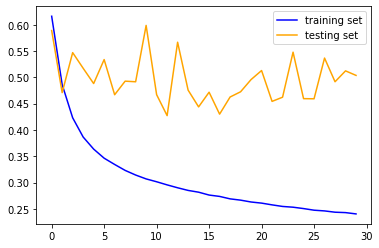

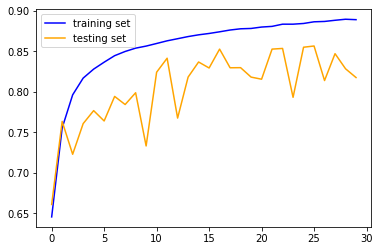

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(30), first_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), first_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

plt.plot(range(30), first_training.history["accuracy"],  label="training set", color = "blue")
plt.plot(range(30), first_training.history["val_accuracy"],  label="testing set", color = "orange")
plt.legend()
plt.show()

Second training

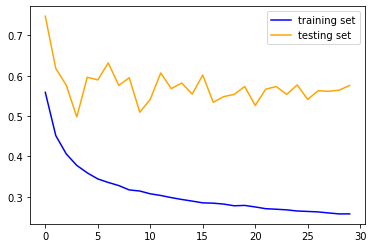

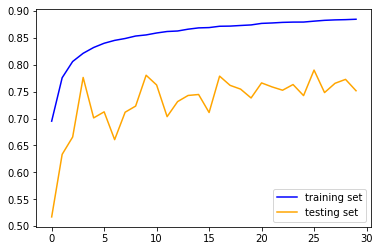

In [36]:
plt.plot(range(30), second_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), second_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

plt.plot(range(30), second_training.history["accuracy"],  label="training set", color = "blue")
plt.plot(range(30), second_training.history["val_accuracy"],  label="testing set", color = "orange")
plt.legend()
plt.show()

Third training

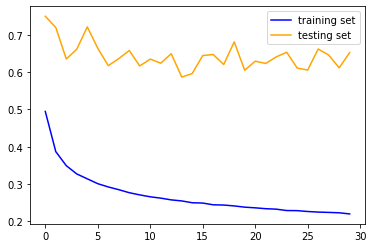

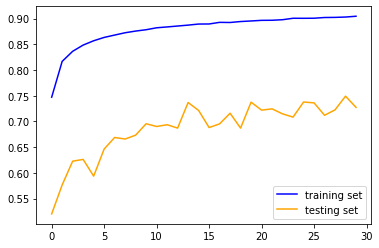

In [37]:
plt.plot(range(30), third_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), third_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

plt.plot(range(30), third_training.history["accuracy"],  label="training set", color = "blue")
plt.plot(range(30), third_training.history["val_accuracy"],  label="testing set", color = "orange")
plt.legend()
plt.show()

Fourth training

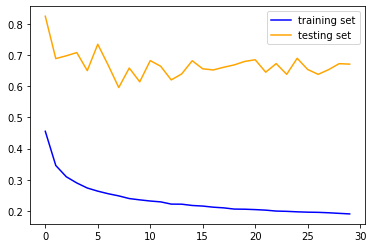

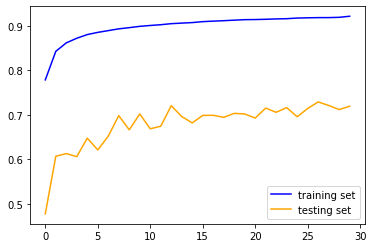

In [38]:
plt.plot(range(30), fourth_training.history["loss"], label="training set", color = "blue")
plt.plot(range(30), fourth_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

plt.plot(range(30), fourth_training.history["accuracy"],  label="training set", color = "blue")
plt.plot(range(30), fourth_training.history["val_accuracy"],  label="testing set", color = "orange")
plt.legend()
plt.show()

Running model on actual labelled data shows a significantly better performance than adding layers of pseudo-labelled data. We try to run the model on the actual labelled data with more sophisticated layers.

In [39]:
pure_model = Sequential([
    Dense(units=300, input_dim=x_train_data.shape[1], activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

pure_model.summary()

pure_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

pure_training = pure_model.fit(x_train_data, y_train_data, batch_size=8, epochs=120, validation_data=(x_test_data, y_test_data))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 300)               10500     
                                                                 
 dense_13 (Dense)            (None, 128)               38528     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
6849/6849 [==============================] - 20s 3ms/step - loss: 0.6188 - accuracy: 0.6423 - val_loss: 0.5716 - val_accuracy: 0.6673
Epoch 2/120
6849/6849 [==============================] - 19s 3ms/step - loss: 0.4933 - accuracy: 0.7530 - val_loss: 0.4946 - val_accuracy: 0.7639
Epoch 3/120
6849/6849 

# Plotting of performance

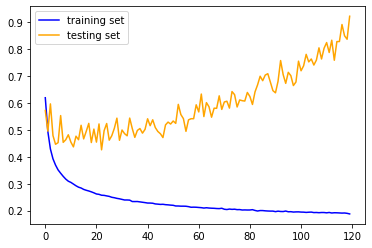

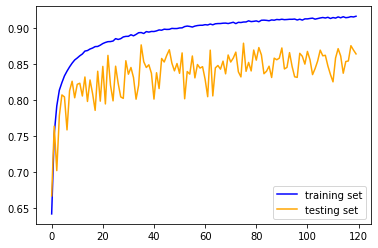

In [40]:
plt.plot(range(120), pure_training.history["loss"], label="training set", color = "blue")
plt.plot(range(120), pure_training.history["val_loss"], label="testing set", color = "orange")
plt.legend()
plt.show()

plt.plot(range(120), pure_training.history["accuracy"],  label="training set", color = "blue")
plt.plot(range(120), pure_training.history["val_accuracy"],  label="testing set", color = "orange")
plt.legend()
plt.show()

# Accuracy of pure model

In [41]:
pure_model_prediction = pure_model.predict(x_test_data)
pure_model_prediction = (pure_model_prediction > 0.5).astype(int)
print(classification_report(y_test_data, pure_model_prediction))

228/228 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.19      0.40      0.26       420
           1       0.96      0.89      0.93      6872

    accuracy                           0.86      7292
   macro avg       0.57      0.65      0.59      7292
weighted avg       0.92      0.86      0.89      7292

